<a href="https://colab.research.google.com/github/euandocking/DSC-uncertainty-quantification-evaluation/blob/main/PyTorch_Uncertainty__Quantification_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install efficientnet for pytorch

In [1]:
!pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=9f346e2879e73667a2743ea1feb6f540aef601ae3d0c156393e21fd3847a13f4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


Import required libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import pandas as pd
import shutil
import random
import torch.nn.functional as F
from torch.utils.data.sampler import WeightedRandomSampler
import time
from datetime import datetime

# use best algorithm for hardware
cudnn.benchmark = True

# interactive mode for graph plot
plt.ion()

Extract data

In [3]:
#copy data zip from drive
from google.colab import drive
drive.mount('/content/drive')
!cp drive/MyDrive/uni/Honours/ISIC_2019.zip ./ISIC_2019.zip

#unzip dataset
!unzip -x -q ISIC_2019.zip

#remove zip file
!rm ISIC_2019.zip

Mounted at /content/drive


Sort data into folders based on class

In [4]:
# function to sort the images into class folders based on given csv file
def copy_images_to_folders(csv_path, image_folder, output_folder):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        image_name = row['image'] + '.jpg'  # Assuming images have '.jpg' extension
        image_path = os.path.join(image_folder, image_name)

        # Iterate through class columns and copy images to the corresponding folders
        for class_name in df.columns[1:]:
            class_folder = os.path.join(output_folder, class_name)
            os.makedirs(class_folder, exist_ok=True)  # Create folder if it doesn't exist

            if row[class_name] == 1:  # Check if the image belongs to the class
                shutil.copy(image_path, class_folder)

csv_path = '/content/ISIC_2019_Training_GroundTruth.csv'
image_folder = '/content/ISIC_2019_Resized'
output_folder = '/content/ISIC_Sorted'

copy_images_to_folders(csv_path, image_folder, output_folder)


Select random subset of data from every class for training and validation

In [5]:
# declare variables for model creation
input_folder = '/content/ISIC_Sorted'  # This is the folder containing class subdirectories
output_folder = '/content/data_subset'  # The desired output folder for "training" and "validation" folders
#data_dir = '/content/data_subset'
num_samples=10000
validation_ratio=0.2
set_batch_size=32

#sample numbers by class copied here for reference
#MEL	NV	  BCC	  AK	BKL	  DF	VASC	SCC	UNK
#4522	12875	3323	867	2624	239	253	  628	0

'''
Melanoma (MEL)
Melanocytic nevus (NV)
Basal cell carcinoma (BCC)
Actinic keratosis (AK)
Benign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]
Dermatofibroma (DF)
Vascular lesion (VASC)
Squamous cell carcinoma (SCC)
None of the others (UNK)
'''

'\nMelanoma (MEL)\nMelanocytic nevus (NV)\nBasal cell carcinoma (BCC)\nActinic keratosis (AK)\nBenign keratosis (BKL) [solar lentigo / seborrheic keratosis / lichen planus-like keratosis]\nDermatofibroma (DF)\nVascular lesion (VASC)\nSquamous cell carcinoma (SCC)\nNone of the others (UNK)\n'

In [6]:
# Remove existing "training" and "validation" folders if they exist
training_folder = os.path.join(output_folder, 'train')
validation_folder = os.path.join(output_folder, 'val')
shutil.rmtree(training_folder, ignore_errors=True)
shutil.rmtree(validation_folder, ignore_errors=True)

# Create the "training" and "validation" folders
os.makedirs(training_folder, exist_ok=True)
os.makedirs(validation_folder, exist_ok=True)

# generate list of class names from the folder structure
class_names = [class_name for class_name in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, class_name))]

In [7]:
# Iterate through each class folder
for class_name in os.listdir(input_folder):
    class_folder_input = os.path.join(input_folder, class_name)
    if os.path.isdir(class_folder_input):
        # Get a list of all images in the class folder
        images = [img for img in os.listdir(class_folder_input) if img.endswith('.jpg')]

        # Randomly shuffle the list of images
        random.shuffle(images)

        #calculate size of class
        class_size = len(os.listdir(os.path.join(input_folder, class_name)))

        # Calculate the number of samples for training and validation
        num_training_samples = int(class_size * (1 - validation_ratio))
        #num_validation_samples = class_size - num_training_samples

        # Create the class subfolders within the "training" and "validation" folders
        class_folder_training = os.path.join(training_folder, class_name)
        class_folder_validation = os.path.join(validation_folder, class_name)
        os.makedirs(class_folder_training, exist_ok=True)
        os.makedirs(class_folder_validation, exist_ok=True)

        # Copy images to the "training" folder
        for image_name in images[:num_training_samples]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_training)

        # Copy images to the "validation" folder
        for image_name in images[num_training_samples:class_size]:
            image_path = os.path.join(class_folder_input, image_name)
            shutil.copy(image_path, class_folder_validation)

In [8]:
#remove unknown folder as no samples
shutil.rmtree("/content/data_subset/train/UNK", ignore_errors=True)
shutil.rmtree("/content/data_subset/val/UNK", ignore_errors=True)

In [9]:
#transform data
data_transforms = {
'train': transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
'val': transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
}

In [10]:
# create datasets and dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=set_batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

#print checks to see if the values are the same - if yes then can remove the assignment here
print(f"file: ", class_names)
class_names = image_datasets['train'].classes
print(f"file: ", class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

file:  ['MEL', 'VASC', 'UNK', 'SCC', 'NV', 'BCC', 'BKL', 'AK', 'DF']
file:  ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [11]:
# get the sample size for each class
class_sizes = [len(os.listdir(os.path.join(training_folder, class_name))) for class_name in class_names]

# get the max sample size across classes
max_class_size = max(class_sizes)

# Calculate the desired repetitions for each class
# this is the number of times a sample needs to be repeated to match the max class size
desired_repetitions = [max_class_size // class_size if class_size > 0 else 1 for class_size in class_sizes]

# Iterate through each class and oversample accordingly
for class_index, class_name in enumerate(class_names):
    #get the training folder for the current class
    class_folder_training = os.path.join(training_folder, class_name)
    class_indices = [i for i, label in enumerate(image_datasets['train'].targets) if label == class_index]

    weights = [1.0 if label != class_index else desired_repetitions[class_index] for label in image_datasets['train'].targets]
    sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

    # Update the data loader for the "training" set with the weighted sampler
    dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'], batch_size=set_batch_size, sampler=sampler, num_workers=2)

show sample images

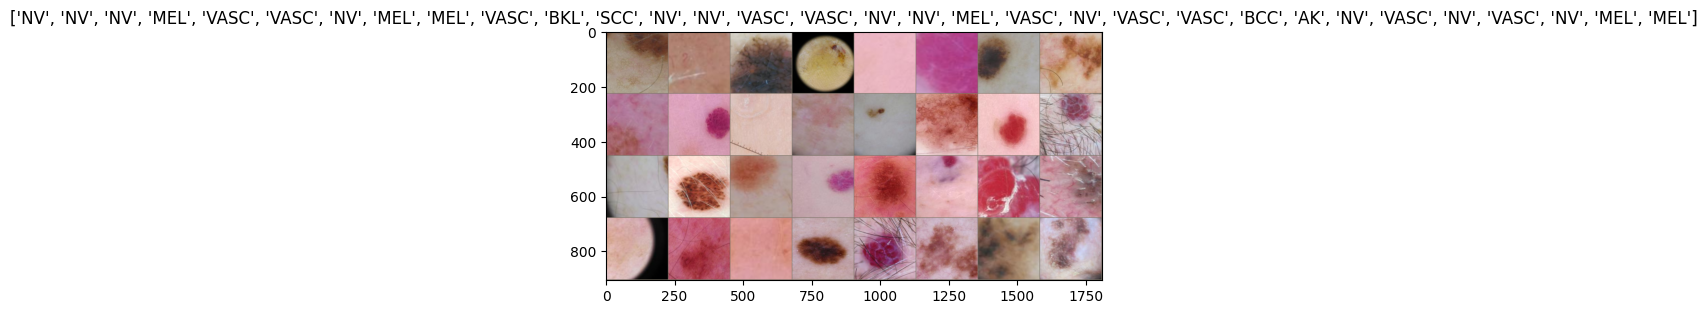

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

model training function

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f'Epoch {epoch}/{num_epochs - 1} - {current_time}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

model visualisation function

temporary fix for efficientnet weights issue

In [14]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

model fitting configuration

In [15]:
model_ft = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 222MB/s]


train model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24 - 2024-01-30 09:33:37
----------
train Loss: 1.5339 Acc: 0.6454
val Loss: 1.1156 Acc: 0.6502

Epoch 1/24 - 2024-01-30 09:35:57
----------
train Loss: 0.8095 Acc: 0.7301


visualise trained model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')

                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                title = f'Predicted: {predicted_class}\nActual: {actual_class}'
                ax.set_title(title)

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
visualize_model(model_ft, num_images=10)

Evaluate the model using softmax activation and store uncertainty and correctness for each sample

In [ ]:
softmax_guesses_are_correct = []
softmax_uncertainties = []

was_training = model_ft.training
model_ft.eval()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(len(inputs)):
          #need to figure out what's causing an index out of bounds error here
          #try-catch block is temp workaround
            try:
                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                softmax_guesses_are_correct.append(actual_class == predicted_class)

                # Compute softmax probabilities
                softmax_probs = F.softmax(outputs[j], dim=0)

                # Calculate uncertainty as an example (you can use a different metric)
                uncertainty = 1 - torch.max(softmax_probs).item()

                softmax_uncertainties.append(uncertainty)
            except IndexError as e:
                continue

    model_ft.train(mode=was_training)

make predictions on validation data with models and store uncertainties for softmax response

In [ ]:
softmax_risks = []

# Loop until all samples are removed
while softmax_uncertainties:
    # Calculate the risk
    risk = 1 - (sum(softmax_guesses_are_correct) / len(softmax_guesses_are_correct))
    softmax_risks.append(risk)

    # Find the index of the sample with the highest uncertainty
    max_uncertainty_index = softmax_uncertainties.index(max(softmax_uncertainties))

    # Remove the sample with the lowest uncertainty from both lists
    softmax_uncertainties.pop(max_uncertainty_index)
    softmax_guesses_are_correct.pop(max_uncertainty_index)

softmax_risks.reverse()

store uncertainty and correctness for each sample using random selection

In [ ]:
random_guesses_are_correct = []
random_uncertainties = []

was_training = model_ft.training
model_ft.eval()

with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        for j in range(len(inputs)):
          #need to figure out what's causing an index out of bounds error here
          #try-catch block is temp workaround
            try:
                predicted_class = class_names[preds[j]]
                actual_class = class_names[labels[j]]
                random_guesses_are_correct.append(actual_class == predicted_class)

                uncertainty = random.uniform(0, 1)

                random_uncertainties.append(uncertainty)
            except IndexError as e:
                continue

    model_ft.train(mode=was_training)

make predictions on validation data with models and store uncertainties for random selection

In [ ]:
random_risks = []

# Loop until all samples are removed
while random_uncertainties:
    # Calculate the risk
    risk = 1 - (sum(random_guesses_are_correct) / len(random_guesses_are_correct))
    random_risks.append(risk)

    # Find the index of the sample with the lowest uncertainty
    max_uncertainty_index = random_uncertainties.index(max(random_uncertainties))

    # Remove the sample with the lowest uncertainty from both lists
    random_uncertainties.pop(max_uncertainty_index)
    random_guesses_are_correct.pop(max_uncertainty_index)

random_risks.reverse()

plot the results

In [ ]:
# Interpolate the data for smoother curves
x_values = np.arange(len(random_risks))
x_smooth = np.linspace(x_values.min(), x_values.max(), 300)

random_risks_smooth = np.interp(x_smooth, x_values, random_risks)
softmax_risks_smooth = np.interp(x_smooth, x_values, softmax_risks)

# Plotting the results with smooth curves
plt.plot(x_smooth, random_risks_smooth, label='Random Risks', linewidth=1)
plt.plot(x_smooth, softmax_risks_smooth, label='Softmax Risks', linewidth=1)

# x axis needs a better name
plt.xlabel('Uncertainty Reduction Steps')
plt.ylabel('Risk')
plt.title('Risk vs. Uncertainty Reduction Steps')

# Adjust the y-axis limits
plt.ylim(0, 1)

# Invert the x-axis
plt.gca().invert_xaxis()

# Show legend
plt.legend()

plt.show()

In [ ]:
# Interpolate the data for smoother curves
x_values = np.arange(len(random_risks))
total_steps = len(x_values)

# Convert x-values to percentage
x_smooth_percentage = (x_values / total_steps) * 100

# Create a smooth range for the x-axis
x_smooth_percentage_interp = np.linspace(x_smooth_percentage.min(), x_smooth_percentage.max(), 300)

# Interpolate the data based on the percentage values
random_risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, random_risks)
softmax_risks_smooth = np.interp(x_smooth_percentage_interp, x_smooth_percentage, softmax_risks)

# Plotting the results with smooth curves
plt.plot(x_smooth_percentage_interp, random_risks_smooth, label='Random Risks', linewidth=1)
plt.plot(x_smooth_percentage_interp, softmax_risks_smooth, label='Softmax Risks', linewidth=1)

# x-axis label with a percentage
plt.xlabel('Coverage (%)')
plt.ylabel('Risk')
plt.title('Risk vs. Coverage')

# Adjust the y-axis limits
plt.ylim(0, 1)

# Invert the x-axis
plt.gca().invert_xaxis()

# Show legend
plt.legend()

plt.show()
